In [173]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.svm import SVR
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import shap
import math
import xarray as xr
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import make_interp_spline, BSpline
shap.initjs()

In [174]:
def set_timestep(df):
    df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%dT%H:%M:%S%z", utc=True)
    df = df.set_index('time')
    return df

In [175]:
def ABS_SHAP(df_shap, df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index()#.drop('index', axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ['Variable', 'Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'red', 'blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable', 'SHAP_abs']
    k2 = k.merge(corr_df, left_on='Variable', right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs', ascending=True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable', y='SHAP_abs', color=colorlist, figsize=(5, 6), legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [7]:
# !!! SKIP if df saved on the disk
import Airly_Download.functions.report_downloader as report_downloader
ids = [80790, 43476, 43114] #London
csv_data = report_downloader.run(ids, '2021-10-01T00:00:00.0Z', '2021-12-11T23:00:00.0Z', avg='HOUR',
                                 status='FINAL', filename='London_Oct_Dec_2021')
df = pd.read_csv(csv_data[0])
df.to_csv(r'G:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data_reports\Shap_Cities_WCCI\Data\London_Oct_Dec_2021.csv', index=False)
df.to_csv(r'C:\Users\mkusy\DataspellProjects\DataToolbox\Reports\Shap_Cities_WCCI\London_Oct_Dec_2021.csv', index=False)

starting data downloader
will download data for installations: [80790, 43476, 43114] dates: 2021-10-01T00:00:00.0Z - 2021-12-11T23:00:00.0Z and averaging: HOUR
downloading all installations...
got 3 installations
tasks: 3, queue: 0
43476tasks: 3, queue: 0 2021-10-01T00:00:00+01:00 2021-11-11T06:00:00Z
2

43114 2021-10-01T00:00:00+01:00 2021-11-11T06:00:00Z
2
43476 2021-11-11T06:00:00Z 2021-12-12T00:00:00Z
queried all parts
43114 2021-11-11T06:00:00Z 2021-12-12T00:00:00Z
queried all parts
tasks: 1, queue: 4
tasks: 1, queue: 3
tasks: 1, queue: 2
tasks: 1, queue: 1
tasks: 1, queue: 0
80790 2021-10-01T00:00:00+01:00 2021-11-11T06:00:00Z
2
tasks: 1, queue: 1
tasks: 1, queue: 0
80790 2021-11-11T06:00:00Z 2021-12-12T00:00:00Z
queried all parts
tasks: 0, queue: 1
tasks: 0, queue: 0
ending
done


In [181]:
# Reading from local disk
df = pd.read_csv(r'C:\Users\mkusy\DataspellProjects\DataToolbox\Reports\Shap_Cities_WCCI\London_Oct_Dec_2021.csv')
df

,id,time,pm1,pm10,pm25,no2,o3,temperature,windSpeed,windBearing,humidity,pressure
0,43476,2021-10-01T00:00:00+01:00,0.35,1.23,0.61,29.47,47.69,15.21,24.66,213.99,95.13,1015.40
1,43476,2021-10-01T01:00:00+01:00,0.35,1.09,0.61,25.62,47.97,15.35,24.08,214.59,95.50,1014.61
2,43476,2021-10-01T02:00:00+01:00,0.71,2.09,1.05,26.64,48.28,15.47,23.76,212.98,95.31,1013.69
3,43476,2021-10-01T03:00:00+01:00,0.36,1.21,0.59,28.56,47.97,15.53,24.09,210.00,94.75,1012.73
4,43476,2021-10-01T04:00:00+01:00,0.01,0.25,0.06,27.80,47.58,15.61,23.76,210.34,94.63,1011.65
...,...,...,...,...,...,...,...,...,...,...,...,...
5182,80790,2021-12-11T19:00:00Z,3.75,8.37,5.53,30.65,47.83,8.82,13.26,210.88,74.32,1015.82
5183,80790,2021-12-11T20:00:00Z,4.29,9.54,6.49,28.49,46.94,9.83,15.53,219.33,79.61,1015.92
5184,80790,2021-12-11T21:00:00Z,4.81,11.35,7.48,23.77,45.97,10.14,15.29,223.32,79.48,1016.05
5185,80790,2021-12-11T22:00:00Z,4.94,12.17,7.99,24.12,42.86,10.27,14.47,227.00,77.60,1016.15


In [182]:
df_ts = set_timestep(df)
df_ts = df_ts.tz_localize(None)
df_ts

,id,pm1,pm10,pm25,no2,o3,temperature,windSpeed,windBearing,humidity,pressure
time,,,,,,,,,,,
2021-09-30 23:00:00,43476,0.35,1.23,0.61,29.47,47.69,15.21,24.66,213.99,95.13,1015.40
2021-10-01 00:00:00,43476,0.35,1.09,0.61,25.62,47.97,15.35,24.08,214.59,95.50,1014.61
2021-10-01 01:00:00,43476,0.71,2.09,1.05,26.64,48.28,15.47,23.76,212.98,95.31,1013.69
2021-10-01 02:00:00,43476,0.36,1.21,0.59,28.56,47.97,15.53,24.09,210.00,94.75,1012.73
2021-10-01 03:00:00,43476,0.01,0.25,0.06,27.80,47.58,15.61,23.76,210.34,94.63,1011.65
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11 19:00:00,80790,3.75,8.37,5.53,30.65,47.83,8.82,13.26,210.88,74.32,1015.82
2021-12-11 20:00:00,80790,4.29,9.54,6.49,28.49,46.94,9.83,15.53,219.33,79.61,1015.92
2021-12-11 21:00:00,80790,4.81,11.35,7.48,23.77,45.97,10.14,15.29,223.32,79.48,1016.05


In [183]:
df_ts.loc[(df_ts.index=='2021-09-30 22:00:00') | (df_ts.index=='2021-09-30 23:00:00')]

,id,pm1,pm10,pm25,no2,o3,temperature,windSpeed,windBearing,humidity,pressure
time,,,,,,,,,,,
2021-09-30 23:00:00,43476,0.35,1.23,0.61,29.47,47.69,15.21,24.66,213.99,95.13,1015.40
2021-09-30 23:00:00,43114,0.43,1.11,0.74,27.05,60.86,15.38,23.02,213.82,94.88,1014.47
2021-09-30 23:00:00,80790,0.47,1.63,0.91,29.52,53.34,15.65,22.95,213.98,94.75,1013.26


In [184]:
# Removing unused variables
for_removal = ['id', 'pm1', 'pm25', 'no2', 'o3']
df_ts = df_ts.drop(for_removal, axis=1)
#df_ts = df_ts.drop(df_ts.index[0:2]) #removal of first two rows
df_ts = df_ts.drop(pd.Timestamp('2021-09-30 23:00:00'))
df_ts

,pm10,temperature,windSpeed,windBearing,humidity,pressure
time,,,,,,
2021-10-01 00:00:00,1.09,15.35,24.08,214.59,95.50,1014.61
2021-10-01 01:00:00,2.09,15.47,23.76,212.98,95.31,1013.69
2021-10-01 02:00:00,1.21,15.53,24.09,210.00,94.75,1012.73
2021-10-01 03:00:00,0.25,15.61,23.76,210.34,94.63,1011.65
2021-10-01 04:00:00,0.51,15.57,24.13,212.84,94.00,1011.02
...,...,...,...,...,...,...
2021-12-11 19:00:00,8.37,8.82,13.26,210.88,74.32,1015.82
2021-12-11 20:00:00,9.54,9.83,15.53,219.33,79.61,1015.92
2021-12-11 21:00:00,11.35,10.14,15.29,223.32,79.48,1016.05


In [185]:
# Variables coding
#directions = np.array('N NE E SE S SW W NW'.split())
#bins = np.arange(0, 360, 45)
#directions = np.array('N NE E SE S SW W NW'.split())
#bins = np.arange(0, 360, 45)
# 3h sampling
df_ts = df_ts.resample('3h').mean()
#df_ts['windBearing'] = directions[np.digitize(df_ts['windBearing'], bins) - 1]
hours = pd.get_dummies(df_ts.index.hour, prefix='hour')
wind_classes = pd.get_dummies(df_ts['windBearing'].values)
#df_ts = df_ts.drop('windBearing', axis=1)
weekends = np.where((df_ts.index.day_name() == 'Saturday') | (df_ts.index.day_name() == 'Sunday'))
weekends = np.asarray(weekends).flatten()
weekdays = np.where((df_ts.index.day_name() != 'Saturday') & (df_ts.index.day_name() != 'Sunday'))
weekdays = np.asarray(weekdays).flatten()
df_ts['WeekEnds'] = 0
df_ts['WeekEnds'][weekends] = 1
df_ts['WeekDays'] = 0
df_ts['WeekDays'][weekdays] = 1
df_ts


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm10,temperature,windSpeed,windBearing,humidity,pressure,WeekEnds,WeekDays
time,,,,,,,,
2021-10-01 00:00:00,1.597778,15.595556,23.034444,212.505556,95.146667,1012.647778,0,1
2021-10-01 03:00:00,0.730000,15.746667,22.760000,213.101111,94.098889,1010.102222,0,1
2021-10-01 06:00:00,2.428889,15.203333,20.793333,216.757778,92.756667,1009.897778,0,1
2021-10-01 09:00:00,5.546667,16.112222,17.720000,232.165556,90.798889,1010.236667,0,1
2021-10-01 12:00:00,1.838889,17.676667,19.330000,249.818889,80.946667,1010.042222,0,1
...,...,...,...,...,...,...,...,...
2021-12-11 09:00:00,10.902222,4.531111,7.583333,239.736667,89.122222,1018.176667,1,0
2021-12-11 12:00:00,10.961111,6.825556,8.793333,211.250000,85.105556,1017.930000,1,0
2021-12-11 15:00:00,16.114444,7.408889,11.274444,191.326667,87.595556,1017.663333,1,0


<AxesSubplot:xlabel='time'>

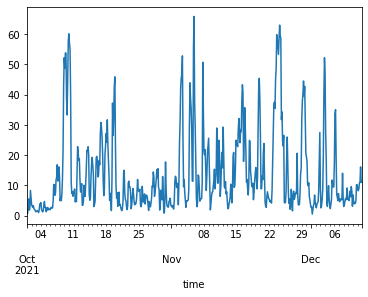

In [186]:
df_ts['pm10'].plot()

In [187]:
# Including wind classes and hour classes
#df_ts[wind_classes.columns] = wind_classes.values
df_ts[hours.columns] = hours.values
df_ts

,pm10,temperature,windSpeed,windBearing,humidity,pressure,WeekEnds,WeekDays,hour_0,hour_3,hour_6,hour_9,hour_12,hour_15,hour_18,hour_21
time,,,,,,,,,,,,,,,,
2021-10-01 00:00:00,1.597778,15.595556,23.034444,212.505556,95.146667,1012.647778,0,1,1,0,0,0,0,0,0,0
2021-10-01 03:00:00,0.730000,15.746667,22.760000,213.101111,94.098889,1010.102222,0,1,0,1,0,0,0,0,0,0
2021-10-01 06:00:00,2.428889,15.203333,20.793333,216.757778,92.756667,1009.897778,0,1,0,0,1,0,0,0,0,0
2021-10-01 09:00:00,5.546667,16.112222,17.720000,232.165556,90.798889,1010.236667,0,1,0,0,0,1,0,0,0,0
2021-10-01 12:00:00,1.838889,17.676667,19.330000,249.818889,80.946667,1010.042222,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11 09:00:00,10.902222,4.531111,7.583333,239.736667,89.122222,1018.176667,1,0,0,0,0,1,0,0,0,0
2021-12-11 12:00:00,10.961111,6.825556,8.793333,211.250000,85.105556,1017.930000,1,0,0,0,0,0,1,0,0,0
2021-12-11 15:00:00,16.114444,7.408889,11.274444,191.326667,87.595556,1017.663333,1,0,0,0,0,0,0,1,0,0


<AxesSubplot:xlabel='expver,time'>

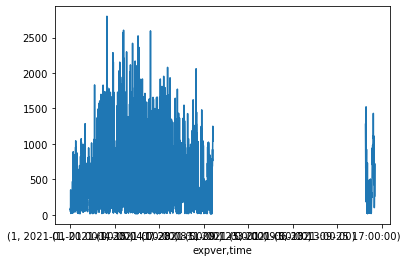

In [35]:
# !!! SKIP if dataframe_CDS saved on the disk
# Acquirng CDS data from cloud
nc_path = r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data_reports\Shap_Cities_WCCI\Data\CDS_data\adaptor.mars.internal-1640712426.304448-12804-4-891be0f3-d0f4-4ea9-97fa-e43b120ceb41.nc'
# nc_path = os.path.join(folder, file)
ds = xr.open_dataset(nc_path)  # NetCDF or OPeNDAP URL
lati = 51.50;
loni = 0.02  # London coordinates [of three instalations]
# Extract a dataset closest to specified point
dsloc = ds.sel(longitude=loni, latitude=lati, method='nearest')
# select a variable to plot
dataframe_CDS = dsloc.to_dataframe()
# Saving to local drive and cloud:
dataframe_CDS.to_csv(r'G:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data_reports\Shap_Cities_WCCI\Data\London_Oct_Dec_2021_CDS_data.csv')
dataframe_CDS.to_csv(r'C:\Users\mkusy\DataspellProjects\DataToolbox\Reports\Shap_Cities_WCCI\London_Oct_Dec_2021_CDS_data.csv')
dataframe_CDS.blh.plot()

In [188]:
# Reading from local disk
dataframe_CDS = pd.read_csv(r'C:\Users\mkusy\DataspellProjects\DataToolbox\Reports\Shap_Cities_WCCI\London_Oct_Dec_2021_CDS_data.csv')
dataframe_CDS['time'] = pd.to_datetime(df['time'], format="%Y-%m-%dT%H:%M:%S", utc=True)
dataframe_CDS = dataframe_CDS.set_index('time')
dataframe_CDS = dataframe_CDS.tz_localize(None)
dataframe_CDS

,expver,longitude,latitude,t2m,blh,tp
time,,,,,,
2021-09-30 23:00:00,1,20.0,50.0,272.90314,73.846680,9.723008e-07
2021-10-01 00:00:00,1,20.0,50.0,273.12247,80.813965,9.723008e-07
2021-10-01 01:00:00,1,20.0,50.0,272.39020,66.572020,4.861504e-07
2021-10-01 02:00:00,1,20.0,50.0,272.72675,42.084473,9.723008e-07
2021-10-01 03:00:00,1,20.0,50.0,272.71396,96.080320,9.723008e-07
...,...,...,...,...,...,...
NaT,5,20.0,50.0,NaN,NaN,6.439714e-04
NaT,5,20.0,50.0,NaN,NaN,5.463557e-04
NaT,5,20.0,50.0,NaN,NaN,3.948333e-04


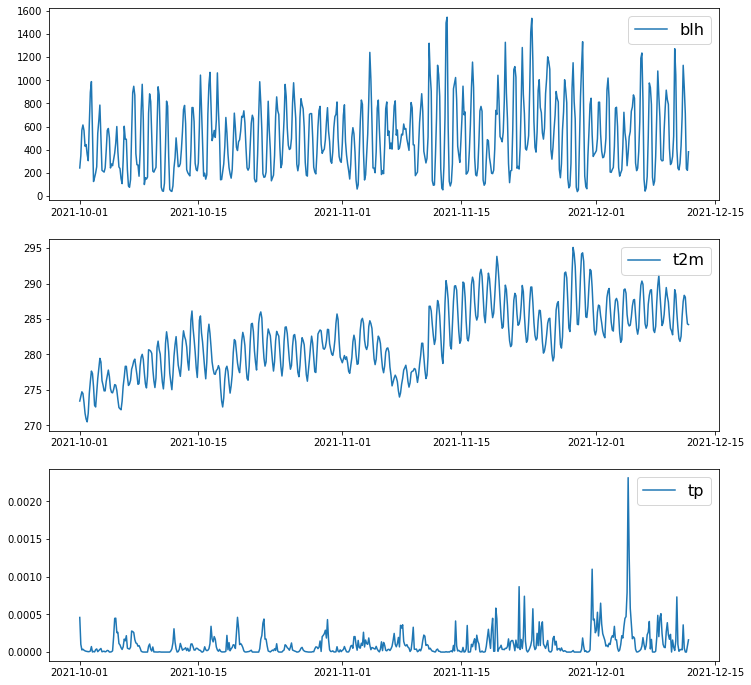

In [189]:
dataframe_CDS_lond = dataframe_CDS.reset_index()
dataframe_CDS_lond.set_index('time', inplace=True)
dataframe_CDS_lond_sep_dec = dataframe_CDS_lond.loc[(dataframe_CDS_lond.index>'2021-10-01') & (dataframe_CDS_lond.index<'2021-12-12')]
dataframe_CDS_lond_sep_dec = dataframe_CDS_lond_sep_dec.resample('3h').mean()
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,12))
ax1.plot(dataframe_CDS_lond_sep_dec.blh, label='blh')
ax2.plot(dataframe_CDS_lond_sep_dec.t2m, label='t2m')
ax3.plot(dataframe_CDS_lond_sep_dec.tp, label='tp')
ax1.legend(prop=dict(size=16))
ax2.legend(prop=dict(size=16))
ax3.legend(prop=dict(size=16))

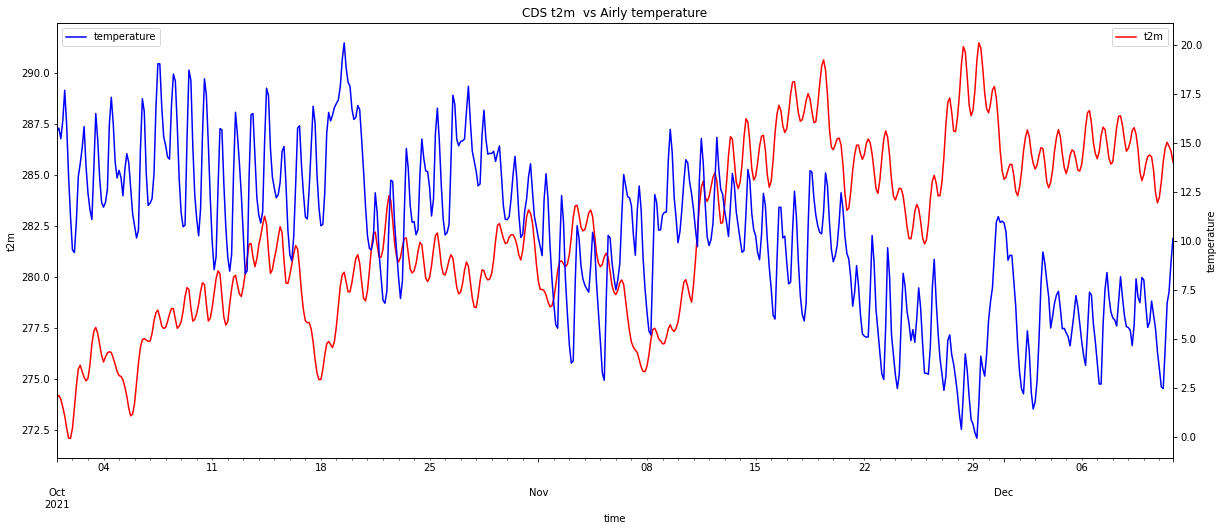

In [190]:
var = 'pm10'
fig, ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
df_final_plot = dataframe_CDS_lond_sep_dec.rolling(center=True, window=6, min_periods=1).mean()
# df_pm10_copy = df_pm10.rolling(center=True, window=6, min_periods=1).mean()
df_ts['temperature'].plot(ax=ax2, label = 'temperature', color ='blue')
df_final_plot.t2m.plot(ax=ax, label = 't2m', color = 'red')
# ax.set_xlim(pd.to_datetime('2021-11-01'), pd.to_datetime('2021-11-30'))
# ax.set_ylim(0,100)
# ax2.set_ylim(0,1000)
plt.title('CDS t2m  vs Airly temperature')
ax2.legend(loc='upper left')
ax2.set_ylabel('temperature')
ax.set_ylabel('t2m')
ax.legend(loc='upper right')
plt.grid(ax2,'minor')
plt.show()

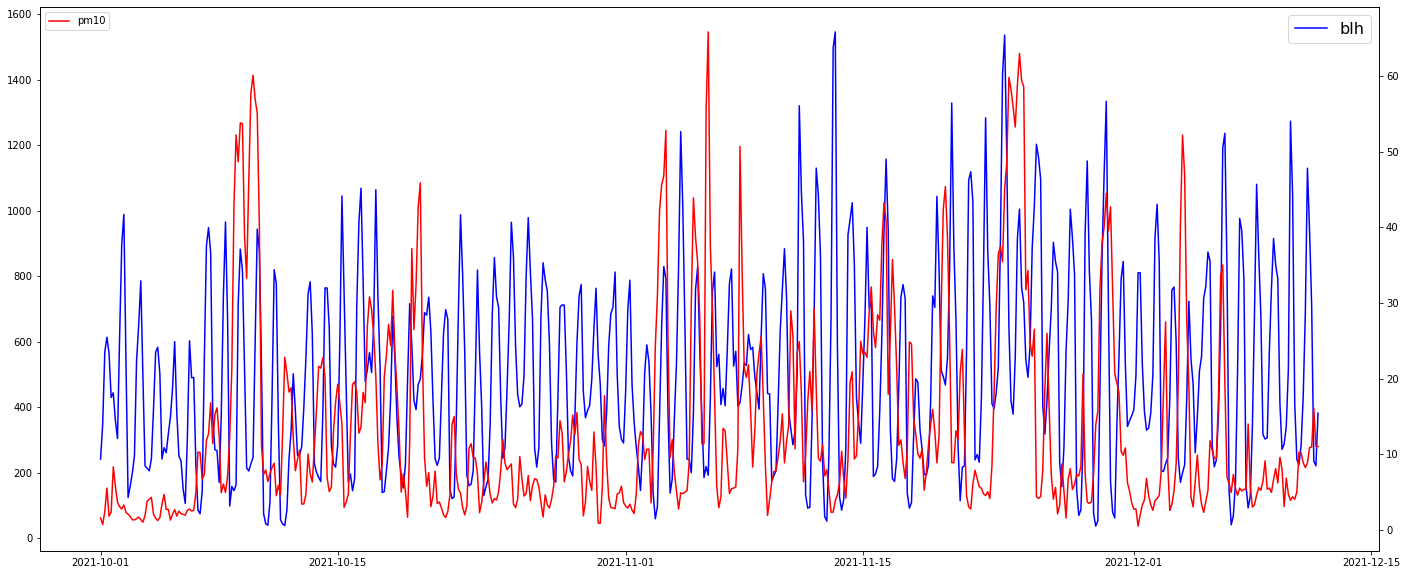

In [191]:
fig, ax = plt.subplots(figsize=(24,10))
ax_ = ax.twinx()
ax.plot(dataframe_CDS_lond_sep_dec.blh, label='blh', color='blue')
ax_.plot(df_ts['pm10'], label='pm10', color='red')
ax.legend(prop=dict(size=16))
ax_.legend(prop=dict(size=16))
ax_.legend(loc='upper left')

In [192]:
dataframe_CDS_lond_sep_dec = dataframe_CDS_lond_sep_dec.drop(['expver', 'longitude', 'latitude', 't2m'], axis=1)
dataframe_CDS_lond_sep_dec

,blh,tp
time,,
2021-10-01 00:00:00,241.554686,0.000459
2021-10-01 03:00:00,347.639463,0.000103
2021-10-01 06:00:00,568.939130,0.000028
2021-10-01 09:00:00,613.531523,0.000037
2021-10-01 12:00:00,565.307538,0.000025
...,...,...
2021-12-11 09:00:00,938.678950,0.000053
2021-12-11 12:00:00,710.628356,0.000001
2021-12-11 15:00:00,235.276257,0.000000


In [193]:
df_final = df_ts.join(dataframe_CDS_lond_sep_dec)
df_final

,pm10,temperature,windSpeed,windBearing,humidity,pressure,WeekEnds,WeekDays,hour_0,hour_3,hour_6,hour_9,hour_12,hour_15,hour_18,hour_21,blh,tp
time,,,,,,,,,,,,,,,,,,
2021-10-01 00:00:00,1.597778,15.595556,23.034444,212.505556,95.146667,1012.647778,0,1,1,0,0,0,0,0,0,0,241.554686,0.000459
2021-10-01 03:00:00,0.730000,15.746667,22.760000,213.101111,94.098889,1010.102222,0,1,0,1,0,0,0,0,0,0,347.639463,0.000103
2021-10-01 06:00:00,2.428889,15.203333,20.793333,216.757778,92.756667,1009.897778,0,1,0,0,1,0,0,0,0,0,568.939130,0.000028
2021-10-01 09:00:00,5.546667,16.112222,17.720000,232.165556,90.798889,1010.236667,0,1,0,0,0,1,0,0,0,0,613.531523,0.000037
2021-10-01 12:00:00,1.838889,17.676667,19.330000,249.818889,80.946667,1010.042222,0,1,0,0,0,0,1,0,0,0,565.307538,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11 09:00:00,10.902222,4.531111,7.583333,239.736667,89.122222,1018.176667,1,0,0,0,0,1,0,0,0,0,938.678950,0.000053
2021-12-11 12:00:00,10.961111,6.825556,8.793333,211.250000,85.105556,1017.930000,1,0,0,0,0,0,1,0,0,0,710.628356,0.000001
2021-12-11 15:00:00,16.114444,7.408889,11.274444,191.326667,87.595556,1017.663333,1,0,0,0,0,0,0,1,0,0,235.276257,0.000000


In [194]:
Y = df_final['pm10'] #Predicted output
X = df_final.drop(['pm10'], axis=1)

In [195]:
X_train = X.loc[X.index < '2021-11-28 00:00:00']
Y_train = Y.loc[X.index < '2021-11-28 00:00:00']
X_test = X.loc[X.index >= '2021-11-28 00:00:00']
Y_test = Y.loc[X.index >= '2021-11-28 00:00:00']

In [196]:
[len(X_train), len(X_test)]

[464, 112]

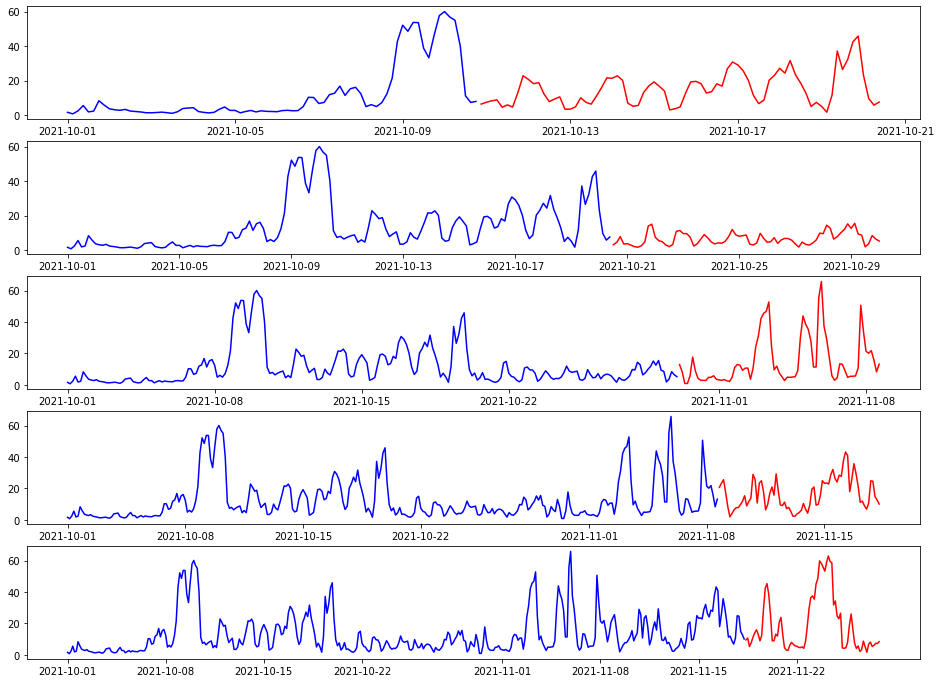

In [197]:
plt.figure(figsize=(16,12), facecolor='white')
index = 1
splits = TimeSeriesSplit(n_splits=5)
for train_index, test_index in splits.split(Y_train):
    train = Y_train[train_index]
    test = Y_train[test_index]
    plt.subplot(510 + index)
    plt.plot(train.index, train, color='blue')
    plt.plot(test.index, test, color='red')
    index += 1
plt.show()

In [198]:
params = {
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4],
    'n_estimators': [500, 1000, 2000]
}
Finder_RF = RandomForestRegressor()
finder = GridSearchCV(
    estimator=Finder_RF,
    param_grid=params,
    scoring='r2',# evaluation index to use when ranking results
    n_jobs=-1, # number of processors
    refit=True, # refitting a model using the best found parameters on the whole dataset.
    cv=splits,  # change this to the splitter subject to test
    verbose=1,
    pre_dispatch=8, # controlling the number of jobs/tasks performed in parallel
    error_score=-999, # parameter related to refitting
    return_train_score=True # returning the score information
)
finder.fit(X_train,Y_train)
best_params = finder.best_params_
best_score = round(finder.best_score_,4)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [199]:
best_params

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 1000}

In [200]:
cv_df = pd.DataFrame(finder.cv_results_)
min_index = abs((cv_df['mean_test_score'] - cv_df['mean_test_score'].mean())).idxmin()
min = abs((cv_df['mean_test_score'] - cv_df['mean_test_score'].mean())).min()
[min, min_index]

[0.000804111543306063, 27]

In [201]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.732264,0.576884,0.127888,0.029436,5,1,2,500,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",-1.743314,...,-0.837408,1.332553,35,0.975851,0.914882,0.879322,0.839262,0.785901,0.879044,0.064675
1,5.164528,0.880750,0.263036,0.039111,5,1,2,1000,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",-1.712999,...,-0.829469,1.344608,30,0.976818,0.913883,0.879019,0.838642,0.788150,0.879302,0.064292
2,10.077488,2.292599,0.470432,0.069051,5,1,2,2000,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",-1.771758,...,-0.822884,1.307516,25,0.976712,0.913586,0.879048,0.840016,0.787475,0.879367,0.064249
3,2.298207,0.604533,0.121817,0.019665,5,1,4,500,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",-1.886098,...,-0.871833,1.365322,44,0.966212,0.908381,0.867899,0.833836,0.778211,0.870908,0.063974
4,4.692646,1.128120,0.234206,0.024069,5,1,4,1000,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",-1.764056,...,-0.828924,1.325716,29,0.966257,0.905166,0.868822,0.834241,0.781798,0.871257,0.062536
5,9.262806,2.158635,0.590444,0.167082,5,1,4,2000,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",-1.771109,...,-0.837293,1.328213,34,0.966863,0.905326,0.870188,0.832209,0.780590,0.871035,0.063320
6,2.641163,0.258169,0.176320,0.043838,5,2,2,500,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",-1.741174,...,-0.772036,1.262209,3,0.956847,0.893794,0.870034,0.830671,0.776083,0.865486,0.060620
7,5.458515,0.922957,0.284277,0.056479,5,2,2,1000,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",-1.714850,...,-0.772208,1.262231,4,0.957131,0.896226,0.867766,0.831897,0.777952,0.866195,0.060228
8,10.616161,1.043559,0.449226,0.016516,5,2,2,2000,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",-1.757767,...,-0.789147,1.285439,15,0.956573,0.897115,0.866574,0.828734,0.778271,0.865453,0.060424
9,2.831365,0.422843,0.140130,0.011555,5,2,4,500,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",-1.853148,...,-0.819258,1.307594,24,0.956425,0.900176,0.865773,0.831205,0.780017,0.866719,0.059910


In [23]:
# {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

[5.359127353551174, 0.4734099517788528]

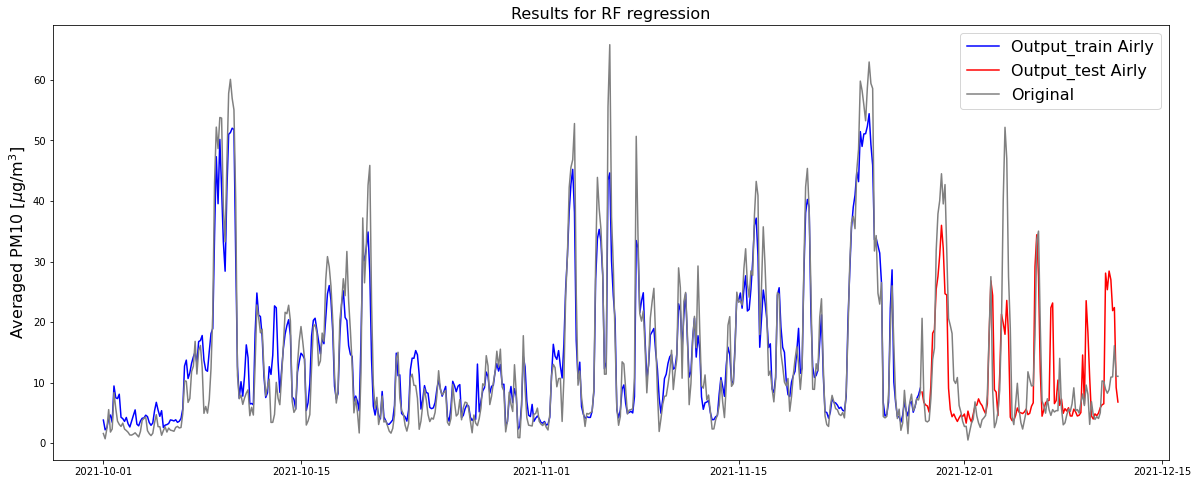

In [202]:
# RF regression
#model_RF = finder.best_estimator_
model_RF = RandomForestRegressor(n_estimators=1000,max_depth=10, min_samples_leaf=2, min_samples_split=2)
model_RF.fit(X_train,Y_train)
Output_test = model_RF.predict(X_test)
Output_train = model_RF.predict(X_train)
# Ploting model's outcomes for RF regression
#%matplotlib notebook
plt.figure(figsize=(20,8), facecolor='white')
plt.plot(X_train.index, Output_train, color='blue', label='Output_train Airly')
plt.plot(X_test.index, Output_test, color='red', label='Output_test Airly')
plt.plot(X.index, Y, color='grey', label='Original')
plt.ylabel('Averaged PM10 [$\mu$g/m$^3$]', fontsize=16)
plt.legend(fontsize=16)
plt.title('Results for RF regression', fontsize=16)
mae = mean_absolute_error(Output_test, Y_test.values)
r2 = r2_score(Y_test.values, Output_test)
[mae, r2]

In [203]:
r2_score(Y_train.values, Output_train)

0.9156395320091778

In [204]:
explainer = shap.TreeExplainer(model_RF)
shap_values = explainer(X_test)
shap_values.base_values = explainer.expected_value[0]
shap_values.values

array([[  3.52226765,  -9.66579246,   0.45719391, ...,  -0.03878951,
         -0.04262461,   0.19712392],
       [  3.71208582, -11.45906751,   0.4457707 , ...,  -0.03674041,
          0.27913419,  -0.25510061],
       [  3.79901427, -11.88022904,   0.40953722, ...,  -0.03953923,
          0.31777384,  -0.33941753],
       ...,
       [  6.23478064,   1.65269084,   0.12261554, ...,  -0.15475884,
         -0.02847697,  -0.22877503],
       [  1.4093871 ,  -7.27872149,   0.44707387, ...,  -0.05874274,
          0.04329576,   0.22110628],
       [ -0.34110832,  -6.54428488,  -1.32602422, ...,   0.50412136,
          0.07862818,   0.36611331]])

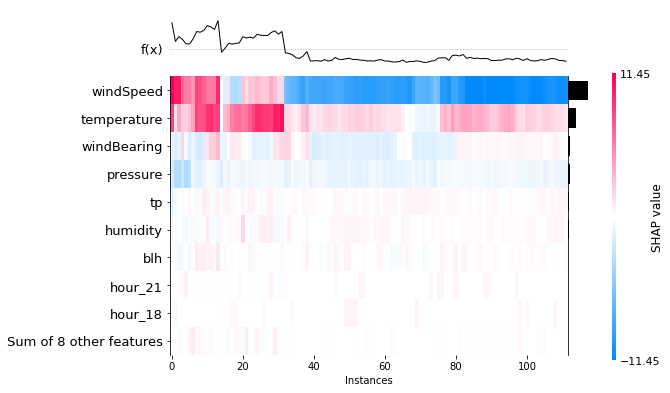

In [205]:
shap.plots.heatmap(shap_values)

In [206]:
shap.plots.force(shap_values)

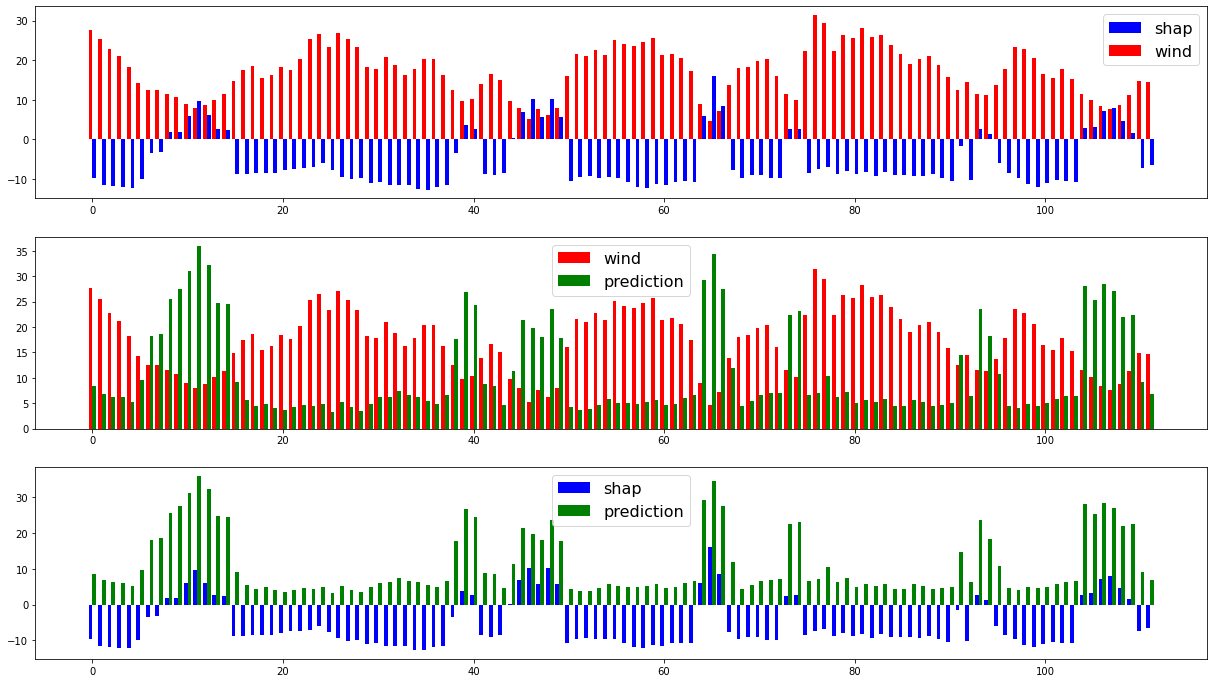

In [207]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(21,12))
x = np.arange(len(X_test))
data_shap_wind = pd.Series(shap_values[:,1].values)
width = 0.4
ax1.bar(x + width/2, data_shap_wind, width, label='shap', color='blue')
ax1.bar(x - width/2, X_test['windSpeed'], width, label='wind', color='red')
ax2.bar(x - width/2, X_test['windSpeed'], width, label='wind', color='red')
ax2.bar(x + width/2, Output_test, width, label='prediction', color='green')
ax3.bar(x - width/2, data_shap_wind, width, label='shap', color='blue')
ax3.bar(x + width/2, Output_test, width, label='prediction', color='green')
ax1.legend(prop=dict(size=16))
ax2.legend(prop=dict(size=16))
ax3.legend(prop=dict(size=16))

In [208]:
# Insight TO MODIFY: 3-rd figure: negative shaps (blue in heatmap) decrease PM10 while positive - increase

In [209]:
ind_sort_wind = np.argsort(X_test['windSpeed'].values)
X_test_sorted_wind = X_test['windSpeed'].values[ind_sort_wind]
Shap_sorted_wind = data_shap_wind[ind_sort_wind]
Prediction_sorted_wind = Output_test[ind_sort_wind]

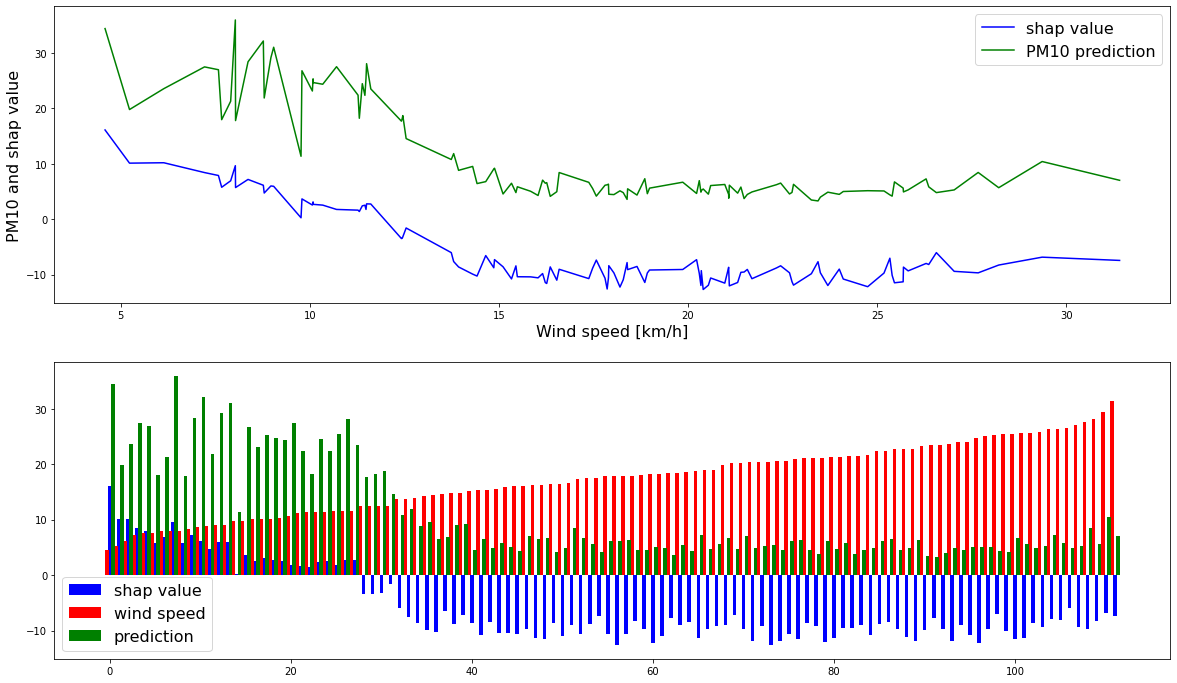

In [210]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
x = np.arange(len(X_test))
width = 0.4
ax1.plot(X_test_sorted_wind, Shap_sorted_wind, label='shap value', color='blue')
ax1.plot(X_test_sorted_wind, Prediction_sorted_wind, label='PM10 prediction', color='green')
ax1.set_ylabel('PM10 and shap value', fontsize=16)
ax1.set_xlabel('Wind speed [km/h]', fontsize=16)
ax2.bar(x, Shap_sorted_wind, width, label='shap value', color='blue')
ax2.bar(x - width/1.2, X_test_sorted_wind, width, label='wind speed', color='red')
ax2.bar(x + width/1.2, Prediction_sorted_wind, width, label='prediction', color='green')
ax1.legend(prop=dict(size=16), loc ="upper right")
ax2.legend(prop=dict(size=16))

In [211]:
# Insights TO MODIFY:
# 1. Positive shap values are determined for low wind speeds which is accompanied by high PM10
# 2. The greater the wind speed the smaller shap values [when negative they remain at fairly constant value]
# 3. Negative shap values correspond to significantly lower PM10
# 4. Blue on the heatmap relates to: increase of windSpeed and decreasing PM10;
# 5. Red on the heatmap relates to: decrease of windSpeed and increasing PM10;

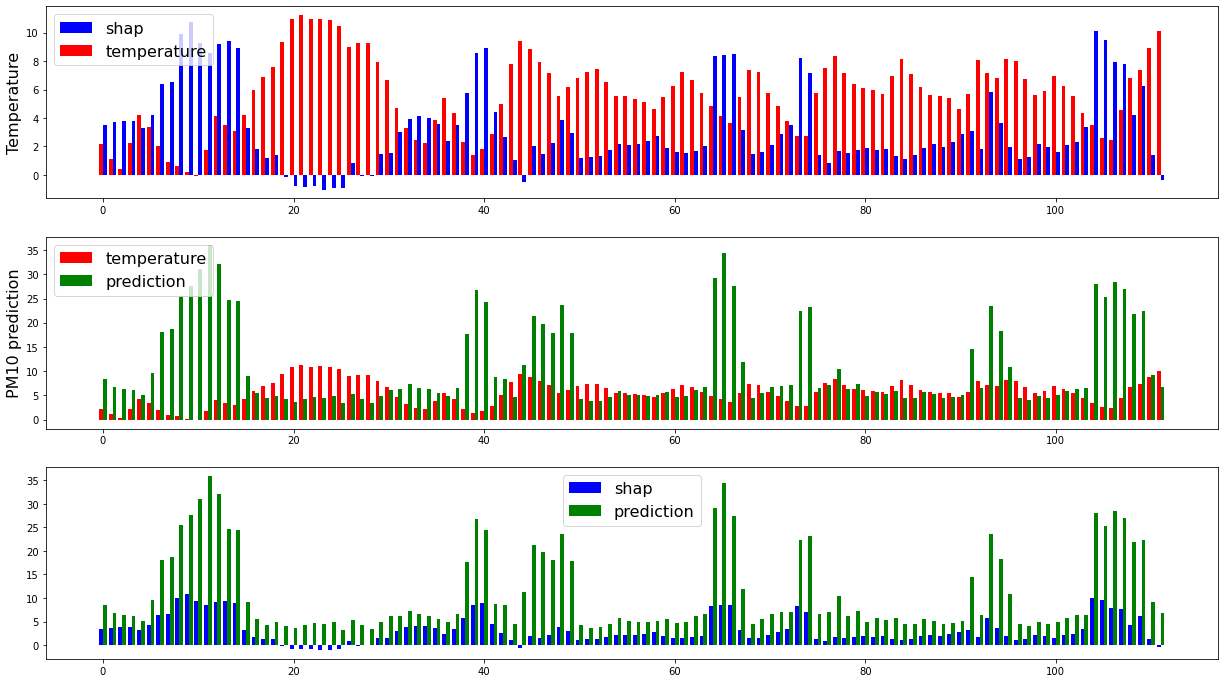

In [212]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(21,12))
x = np.arange(len(X_test))
data_shap_temp = pd.Series(shap_values[:,0].values)
width = 0.4
ax1.bar(x + width/2, data_shap_temp, width, label='shap', color='blue')
ax1.set_ylabel('Shap value', fontsize=16)
ax1.bar(x - width/2, X_test['temperature'], width, label='temperature', color='red')
ax1.set_ylabel('Temperature', fontsize=16)
ax2.bar(x - width/2, X_test['temperature'], width, label='temperature', color='red')
ax2.set_ylabel('Temperature', fontsize=16)
ax2.bar(x + width/2, Output_test, width, label='prediction', color='green')
ax2.set_ylabel('PM10 prediction', fontsize=16)
ax3.bar(x - width/2, data_shap_temp, width, label='shap', color='blue')
ax3.bar(x + width/2, Output_test, width, label='prediction', color='green')
ax1.legend(prop=dict(size=16), loc ="upper left")
ax2.legend(prop=dict(size=16), loc ="upper left")
ax3.legend(prop=dict(size=16))

In [213]:
# Insight TO MODIFY: 3-rd figure: usually, negative shaps (blue in heatmap) decrease PM10 while positive - increase. In the cases when this is not the case (e.g.: {19, 20, 21} or {108, 109, 110}) it is necessary to include the impact of the windSpeed feature, which is low then.

In [214]:
ind_sort_temp = np.argsort(X_test['temperature'].values)
X_test_sorted_temp = X_test['temperature'].values[ind_sort_temp]
Shap_sorted_temp = data_shap_temp[ind_sort_temp]
Prediction_sorted_temp = Output_test[ind_sort_temp]

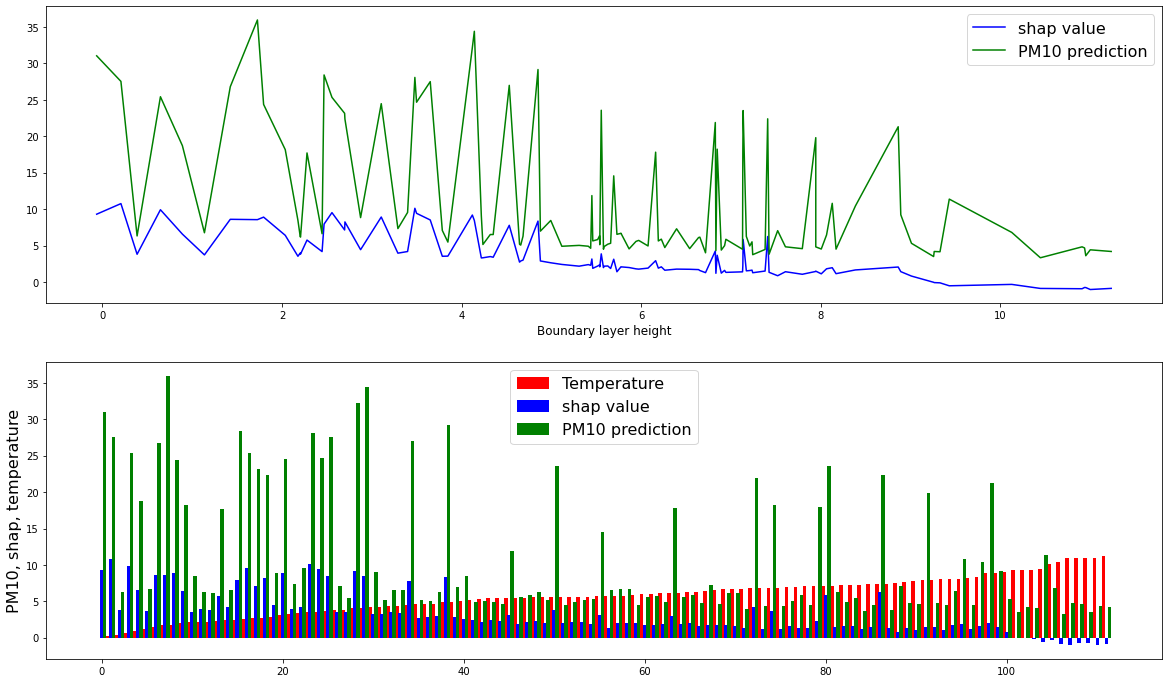

In [215]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
x = np.arange(len(X_test))
width = 0.4
ax1.plot(X_test_sorted_temp, Shap_sorted_temp, label='shap value', color='blue')
ax1.plot(X_test_sorted_temp, Prediction_sorted_temp, label='PM10 prediction', color='green')
ax1.set_xlabel('Boundary layer height', fontsize=12)
ax1.legend(prop=dict(size=16), loc ="upper right")
ax2.bar(x - width/1.2, X_test_sorted_temp, width, label='Temperature', color='red')
ax2.bar(x, Shap_sorted_temp, width, label='shap value', color='blue')
ax2.bar(x + width/1.2, Prediction_sorted_temp, width, label='PM10 prediction', color='green')
ax2.set_ylabel('PM10, shap, temperature', fontsize=16)
ax2.legend(prop=dict(size=16), loc ="upper center")

In [216]:
# Insights TO MODIFY:
# 1. Positive shap values are determined for low blh (<200m) speeds which is accompanied by many high PM10 peaks
# 2. The greater the blh value the smaller shap values [when negative they remain at fairly constant value]
# 3. Negative shap values correspond to lower PM10; howerever some peaks occur - they result from low wind speed
# 4. Blue on the heatmap relates to: increase of blh and increase of PM10 (pale blue);
# 5. Red on the heatmap relates to: decrease of blh and increase PM10 (strong red);

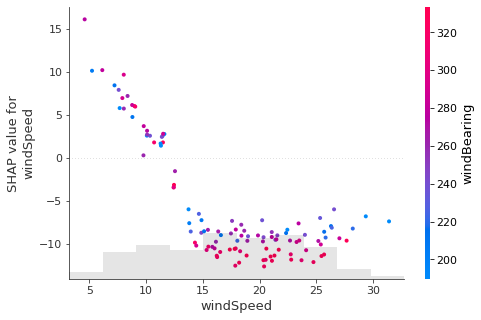

In [217]:
shap.plots.scatter(shap_values[:,1], color=shap_values)

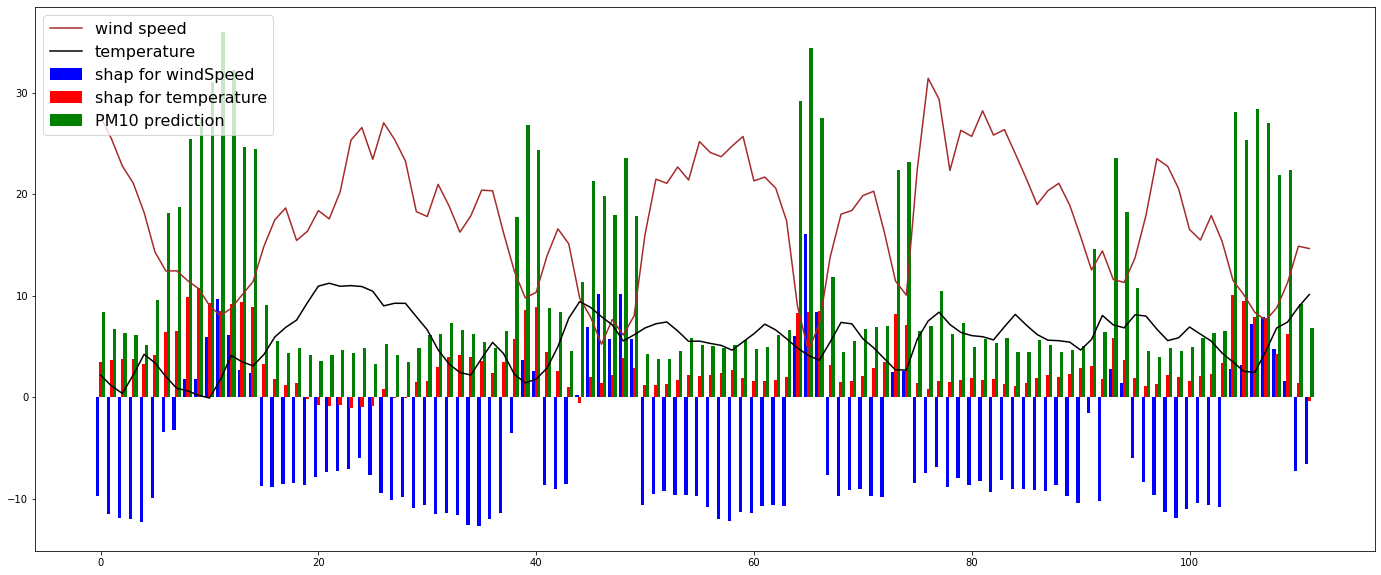

In [218]:
fig, ax = plt.subplots(figsize=(24,10))
x = np.arange(len(X_test))
width = 0.3
ax.bar(x - width/1.2, data_shap_wind, width, label='shap for windSpeed', color='blue')
ax.bar(x, data_shap_temp, width, label='shap for temperature', color='red')
ax.bar(x + width/1.2, Output_test, width, label='PM10 prediction', color='green')
ax.plot(X_test['windSpeed'].values, label='wind speed', color='brown')
ax.plot(X_test['temperature'].values, label='temperature', color='black')
ax.legend(prop=dict(size=16), loc='upper left')

In [219]:
base = shap_values.base_values * np.ones(len(X_test))

In [220]:
base_shift = np.zeros(len(X_test))
i = 0
for i in range(len(X_test)):
    base_shift[i] = shap_values.base_values + sum(shap_values.values[i,2:24])
base_shift

array([14.59659263, 14.49894794, 14.39537194, 14.35305008, 14.05617572,
       15.2642728 , 15.20110441, 15.31469431, 13.7391023 , 15.0042478 ,
       15.7963939 , 17.75088466, 16.85393713, 12.56180962, 13.13830524,
       14.53922556, 12.59335457, 11.6794376 , 11.82762958, 12.86563809,
       12.18342698, 12.43119285, 12.7172406 , 12.47695363, 11.77339998,
       11.86842392, 13.89124382, 14.38257815, 13.36057452, 14.23562562,
       15.20932088, 14.80795182, 14.77724743, 14.03595291, 14.83916075,
       14.59989801, 14.46536052, 14.45482026, 15.43899271, 14.52908838,
       12.91867727, 13.00762794, 14.8317548 , 12.08971147, 11.63006633,
       12.31732387,  8.23794958,  9.96996305,  9.51789861,  9.17530527,
       13.6821485 , 11.99752732, 11.73067819, 12.49205813, 13.20922383,
       12.75121197, 13.63502692, 14.44409737, 14.60804446, 15.04677083,
       14.52006727, 14.09222537, 14.99489825, 15.32665317, 14.79414642,
        9.85396484, 10.56384357, 16.33880664, 12.64733926, 12.97

Text(0.5, 0, 'Subsequent testing samples')

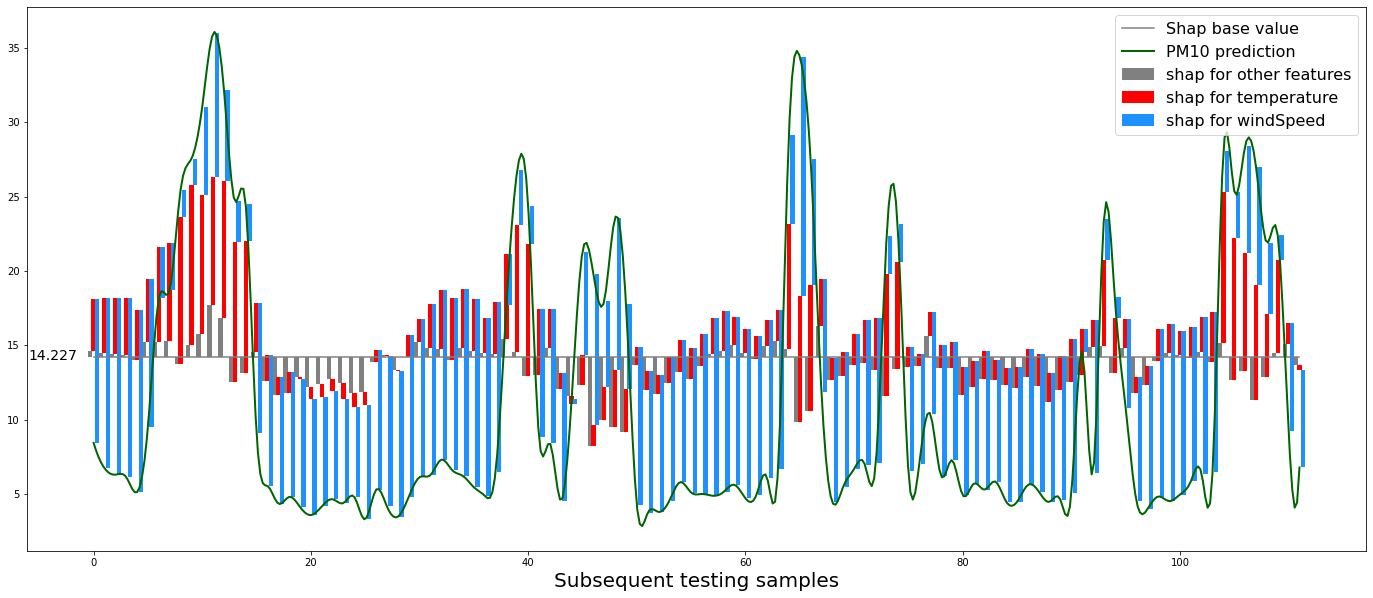

In [221]:
fig, ax = plt.subplots(figsize=(24,10))
ax.plot(base, label='Shap base value', color='grey')
x = np.arange(len(X_test))
xnew = np.linspace(x.min(), x.max(), 500)
spl_outpput = make_interp_spline(x, Output_test, k=3)
spl_wind = make_interp_spline(x, X_test['windSpeed'].values, k=3)
spl_temp = make_interp_spline(x, X_test['temperature'].values, k=3)
y_smooth_outpput = spl_outpput(xnew)
y_smooth_wind = spl_wind(xnew)
y_smooth_temp = spl_temp(xnew)
ax.plot(xnew, y_smooth_outpput, label='PM10 prediction', color='darkgreen', linewidth=2)
#ax.plot(xnew, y_smooth_wind, label='wind speed', color='black')
#ax.plot(xnew, y_smooth_temp, label='temperature', color='brown')
width = 0.4
ax.bar(x - width/1.2, base_shift-shap_values.base_values, width, bottom = base, label='shap for other features', color='grey')
ax.bar(x, data_shap_temp, width, bottom = base_shift, label='shap for temperature', color='red')
ax.bar(x + width/1.2, data_shap_wind, width, bottom = base_shift+data_shap_temp, label='shap for windSpeed', color='dodgerblue')
#ax.plot(X_test['windSpeed'].values, label='wind speed', color='brown')
#ax.plot(X_test['temperature'].values, label='temperature', color='black')
ax.legend(prop=dict(size=16), loc='upper right')
plt.text(-6, 14, '14.227', fontsize = 14)
ax.set_xlabel('Subsequent testing samples', fontsize=20)

Text(0.5, 0, 'Subsequent testing samples')

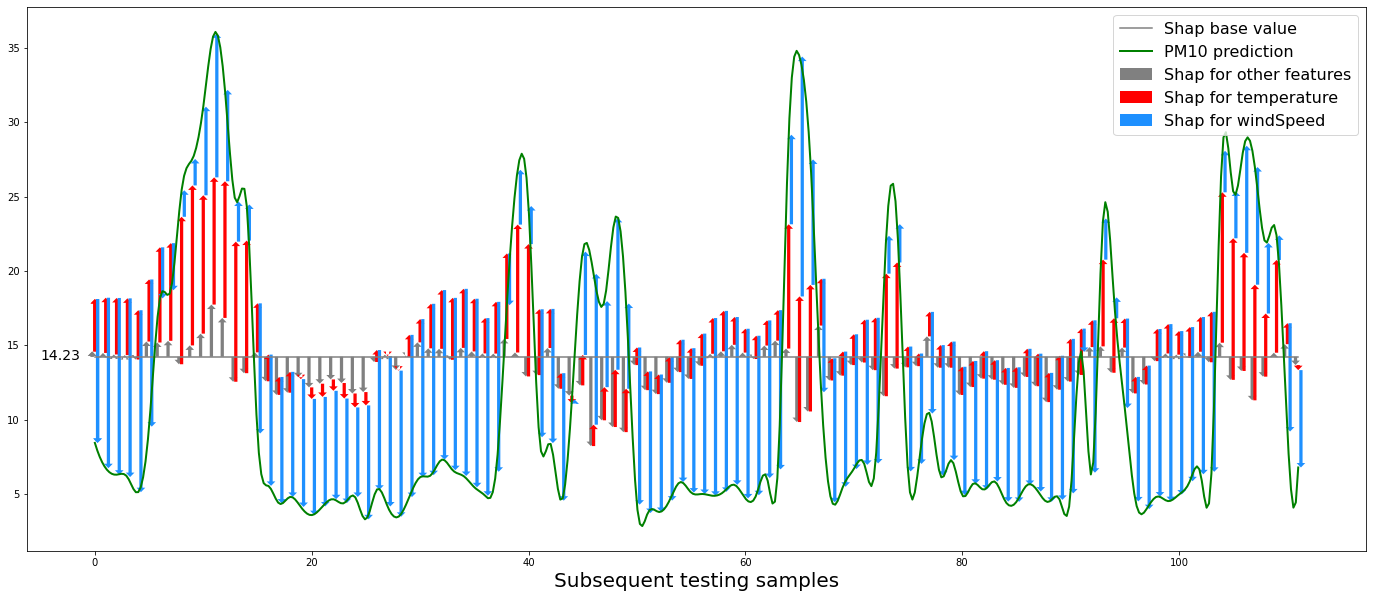

In [222]:
fig, ax = plt.subplots(figsize=(24,10))
ax.plot(base, label='Shap base value', color='grey')
x = np.arange(len(X_test))
zeros_ = np.zeros(len(X_test))
xnew = np.linspace(x.min(), x.max(), 500)
spl_outpput = make_interp_spline(x, Output_test, k=3)
y_smooth_outpput = spl_outpput(xnew)
ax.plot(xnew, y_smooth_outpput, label='PM10 prediction', color='green', linewidth=2)
width = 0.3
for i in range(len(X_test)):
    if i == 0:
        ax.arrow(x=x[0] - width/1.2, y=base[0], dx=zeros_[0], dy=base_shift[0]-base[0] , width=width, facecolor='grey', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8, label='Shap for other features')
        ax.arrow(x=x[0], y=base_shift[0], dx=zeros_[0], dy=data_shap_temp[0], width=width, facecolor='red', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8, label='Shap for temperature')
        ax.arrow(x=x[0] + width/1.2, y=base_shift[0]+data_shap_temp[0], dx=zeros_[0], dy=data_shap_wind[0], width=width, facecolor='dodgerblue', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8, label='Shap for windSpeed')
    ax.arrow(x=x[i] - width/1.2, y=base[i], dx=zeros_[i], dy=base_shift[i]-base[i] , width=width, facecolor='grey', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
    ax.arrow(x=x[i], y=base_shift[i], dx=zeros_[i], dy=data_shap_temp[i], width=width, facecolor='red', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
    ax.arrow(x=x[i] + width/1.2, y=base_shift[i]+data_shap_temp[i], dx=zeros_[i], dy=data_shap_wind[i], width=width, facecolor='dodgerblue', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
ax.legend(prop=dict(size=16), loc='upper right')
plt.text(-5, 14, '14.23', fontsize = 14)
ax.set_xlabel('Subsequent testing samples', fontsize=20)

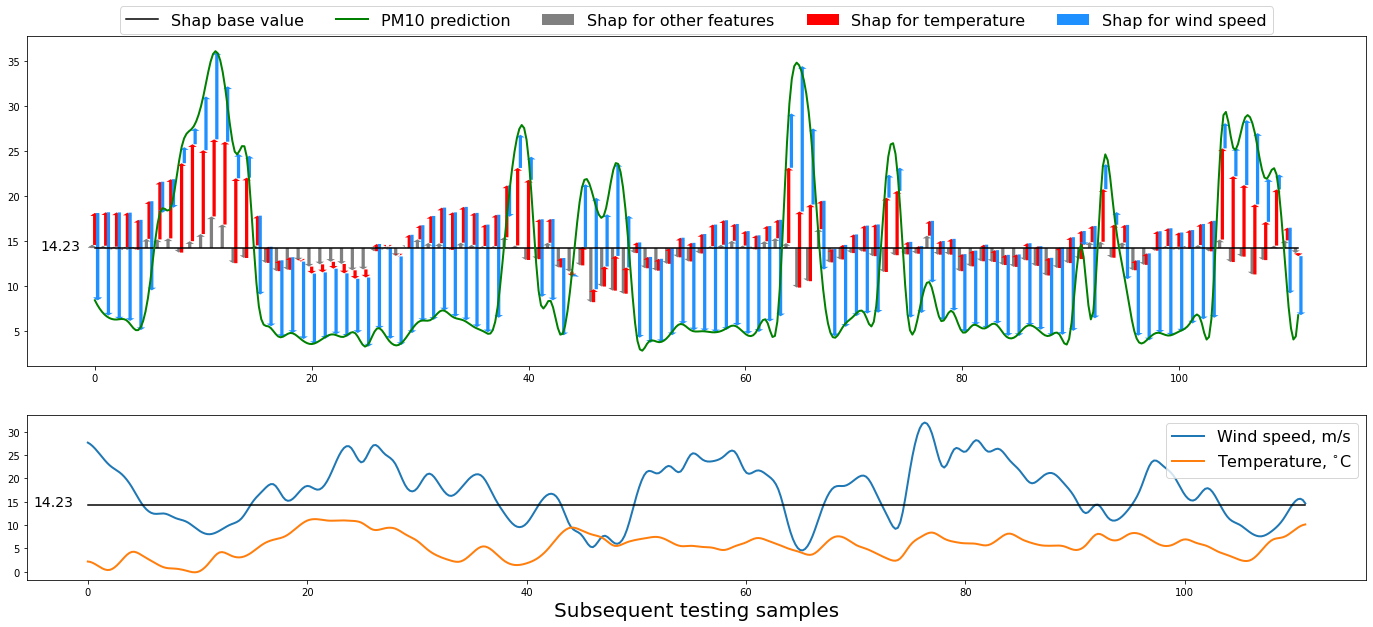

In [223]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(24,10), gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(base, label='Shap base value', color='black')
x = np.arange(len(X_test))
zeros_ = np.zeros(len(X_test))
xnew = np.linspace(x.min(), x.max(), 500)
spl_outpput = make_interp_spline(x, Output_test, k=3)
spl_wind = make_interp_spline(x, X_test['windSpeed'].values, k=3)
spl_temp = make_interp_spline(x, X_test['temperature'].values, k=3)
y_smooth_outpput = spl_outpput(xnew)
y_smooth_wind = spl_wind(xnew)
y_smooth_temp = spl_temp(xnew)
ax1.plot(xnew, y_smooth_outpput, label='PM10 prediction', color='green', linewidth=2)
width = 0.3
for i in range(len(X_test)):
    if i == 0:
        ax1.arrow(x=x[0] - width/1.2, y=base[0], dx=zeros_[0], dy=base_shift[0]-base[0] , width=width, facecolor='grey', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8, label='Shap for other features')
        ax1.arrow(x=x[0], y=base_shift[0], dx=zeros_[0], dy=data_shap_temp[0], width=width, facecolor='red', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8, label='Shap for temperature')
        ax1.arrow(x=x[0] + width/1.2, y=base_shift[0]+data_shap_temp[0], dx=zeros_[0], dy=data_shap_wind[0], width=width, facecolor='dodgerblue', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8, label='Shap for wind speed')
    ax1.arrow(x=x[i] - width/1.2, y=base[i], dx=zeros_[i], dy=base_shift[i]-base[i] , width=width, facecolor='grey', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
    ax1.arrow(x=x[i], y=base_shift[i], dx=zeros_[i], dy=data_shap_temp[i], width=width, facecolor='red', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
    ax1.arrow(x=x[i] + width/1.2, y=base_shift[i]+data_shap_temp[i], dx=zeros_[i], dy=data_shap_wind[i], width=width, facecolor='dodgerblue', edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.115), ncol=5, fancybox=True, fontsize=16)
ax1.text(-5, 14, '14.23', fontsize = 14)
ax2.set_xlabel('Subsequent testing samples', fontsize=20)
ax2.plot(xnew, y_smooth_wind, label='Wind speed, m/s', linewidth=2)
ax2.plot(xnew, y_smooth_temp, label='Temperature, $^{\circ}$C', linewidth=2)
ax2.plot(base, color='black')
ax2.text(-5, 14, '14.23', fontsize = 14)
ax2.legend(fontsize=16)
#fig.tight_layout(pad=5.0)

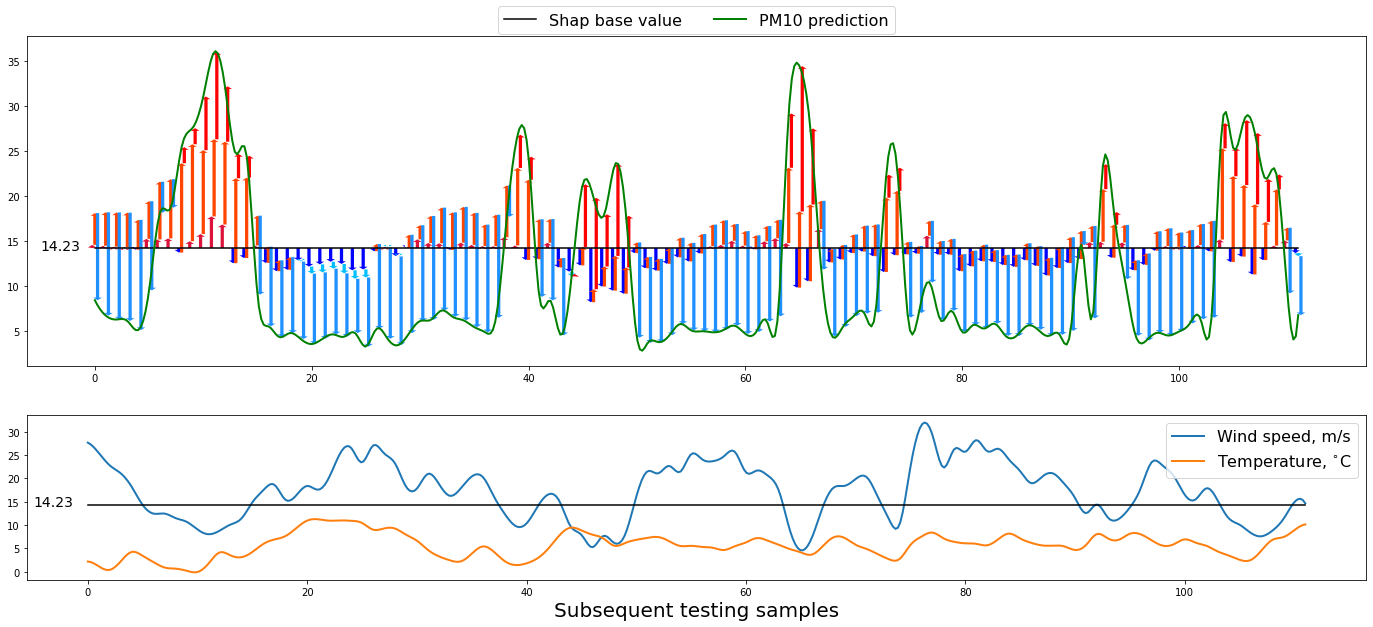

In [224]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(24,10), gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(base, label='Shap base value', color='black')
x = np.arange(len(X_test))
zeros_ = np.zeros(len(X_test))
xnew = np.linspace(x.min(), x.max(), 500)
spl_outpput = make_interp_spline(x, Output_test, k=3)
spl_wind = make_interp_spline(x, X_test['windSpeed'].values, k=3)
spl_temp = make_interp_spline(x, X_test['temperature'].values, k=3)
y_smooth_outpput = spl_outpput(xnew)
y_smooth_wind = spl_wind(xnew)
y_smooth_temp = spl_temp(xnew)
ax1.plot(xnew, y_smooth_outpput, label='PM10 prediction', color='green', linewidth=2)
width = 0.3
for i in range(len(X_test)):
    color = np.where(base_shift[i]-base[i] > 0, 'crimson', 'blue').item()
    ax1.arrow(x=x[i] - width/1.2, y=base[i], dx=zeros_[i], dy=base_shift[i]-base[i] , width=width, facecolor=color, edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
    color = np.where(data_shap_temp[i] > 0, 'orangered', 'deepskyblue').item()
    ax1.arrow(x=x[i], y=base_shift[i], dx=zeros_[i], dy=data_shap_temp[i], width=width, facecolor=color, edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
    color = np.where(data_shap_wind[i] > 0, 'red', 'dodgerblue').item()
    ax1.arrow(x=x[i] + width/1.2, y=base_shift[i]+data_shap_temp[i], dx=zeros_[i], dy=data_shap_wind[i], width=width, facecolor=color, edgecolor='none', length_includes_head=True, head_length=.3, head_width=.8)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.115), ncol=5, fancybox=True, fontsize=16)
ax1.text(-5, 14, '14.23', fontsize = 14)
ax2.set_xlabel('Subsequent testing samples', fontsize=20)
ax2.plot(xnew, y_smooth_wind, label='Wind speed, m/s', linewidth=2)
ax2.plot(xnew, y_smooth_temp, label='Temperature, $^{\circ}$C', linewidth=2)
ax2.plot(base, color='black')
ax2.text(-5, 14, '14.23', fontsize = 14)
ax2.legend(fontsize=16)

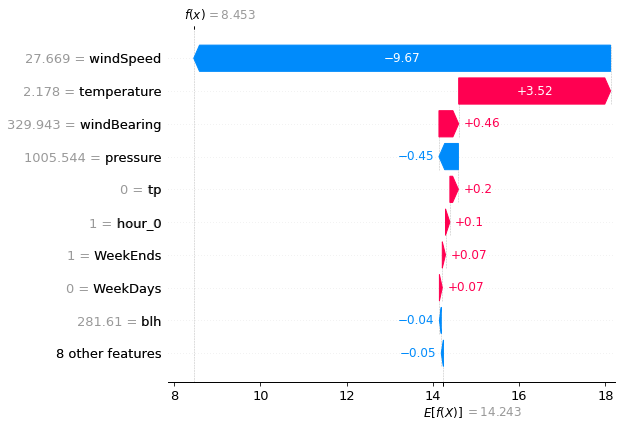

In [225]:
shap.plots.waterfall(shap_values[0])

In [45]:
# Insights TO MODIFY:
# 1. Negative values of shap for windSpeed and blh correspond to high value of wind and low PM10;
# 2. Positive values of shap for windspeed have greater influence on PM10 than negative values of shap for blh;

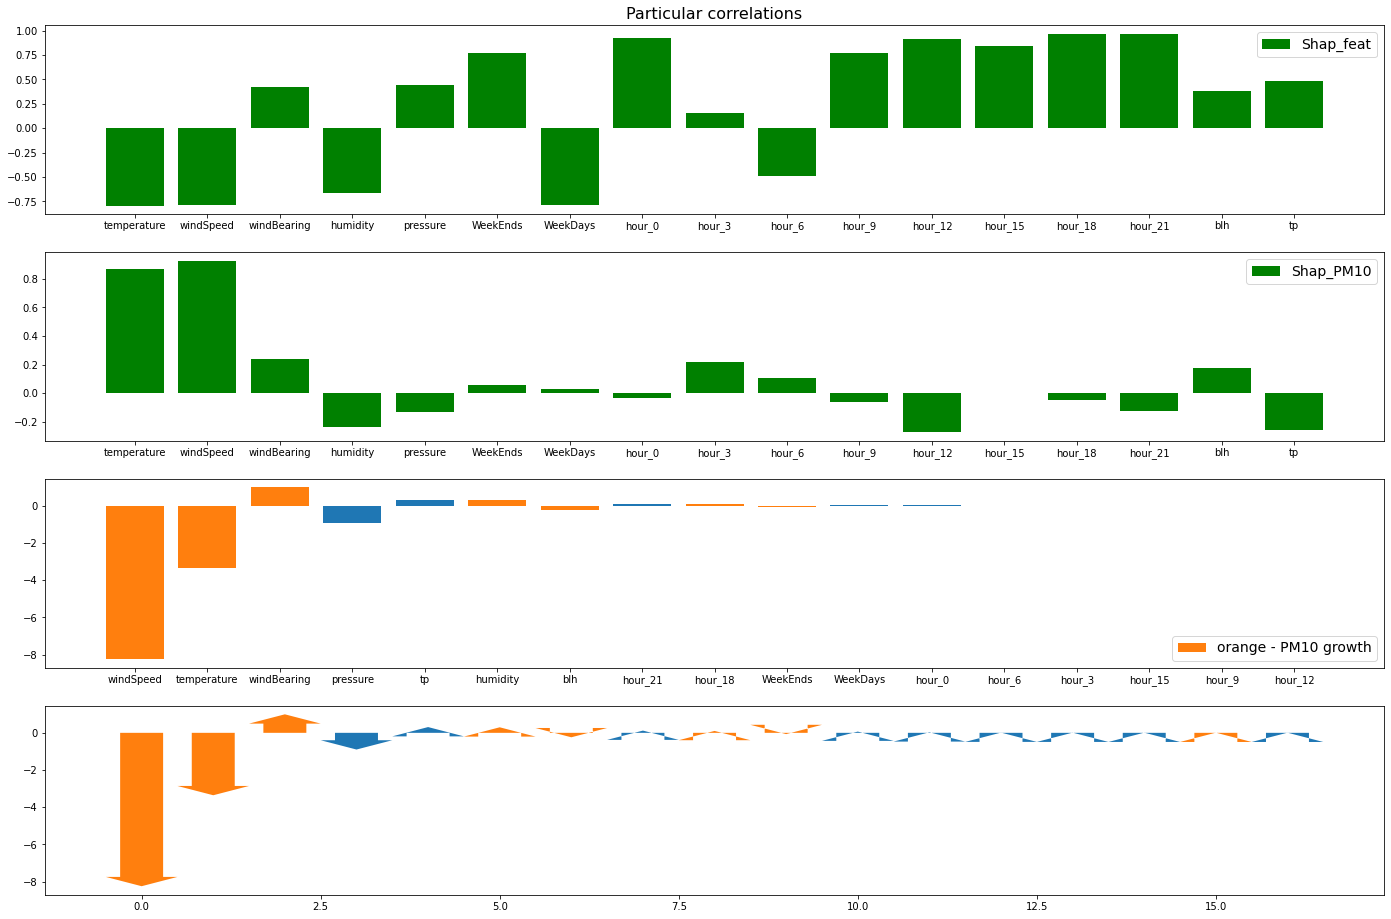

In [226]:
dim = len(X_test.columns)
shap_importance = np.zeros(dim)
for i in range(dim):
    shap_importance[i] = np.abs(shap_values.values[:,i]).mean()
shapley_importance_sort_ind = np.argsort(shap_importance)[::-1]
shap_PM10_corr = np.zeros(dim)
shap_feat_corr = np.zeros(dim)
feat_PM10_corr = np.zeros(dim)
for i in range(dim):
    shap_PM10_corr[i] = np.corrcoef(shap_values.values[:,i], Output_test)[1][0]
    shap_feat_corr[i] = np.corrcoef(shap_values.values[:,i], X_test[X_test.columns[i]])[1][0]
    feat_PM10_corr[i] = np.corrcoef(X_test[X_test.columns[i]], Output_test)[1][0]
np.nan_to_num(shap_PM10_corr, 0)
np.nan_to_num(shap_feat_corr, 0)
np.nan_to_num(feat_PM10_corr, 0)
signs_shap_feat_corr = np.zeros(dim)
signs_shap_feat_corr = np.sign(shap_feat_corr)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(24,16))
ax1.set_title('Particular correlations', fontsize=16)
ax1.bar(X_test.columns, shap_feat_corr, color='green', label = 'Shap_feat')
ax1.legend(fontsize=14)
ax2.bar(X_test.columns, shap_PM10_corr, color='green', label = 'Shap_PM10')
ax2.legend(fontsize=14)
ax3.bar(X_test.columns[shapley_importance_sort_ind], signs_shap_feat_corr*shap_importance[shapley_importance_sort_ind], color=np.where(shap_PM10_corr > 0, '#ff7f0e', '#1f77b4'), label = 'orange - PM10 growth')
ax3.legend(fontsize=14)
X_indices = np.arange(len(X_test.columns))
for i in range(dim):
    color = np.where(shap_PM10_corr[i] > 0, '#ff7f0e', '#1f77b4').item()
    ax4.arrow(x=X_indices[i], y=0, dx=0, dy=signs_shap_feat_corr[i]*shap_importance[shapley_importance_sort_ind[i]] , width=0.6, facecolor=color, edgecolor='none', length_includes_head=True, head_length=.5, head_width=1)
#ax3.bar(X_test.columns, feat_PM10_corr, color='green', label = 'Feat_PM10')
#ax3.legend(fontsize=14)

In [231]:
signs_shap_feat_corr

array([-1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

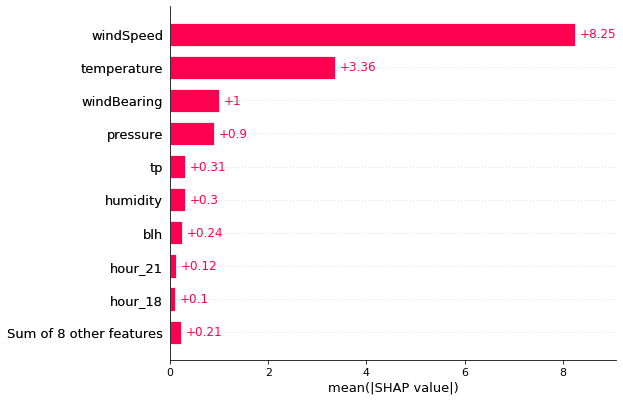

In [230]:
shap.plots.bar(shap_values)

invalid value encountered in true_divide
invalid value encountered in true_divide


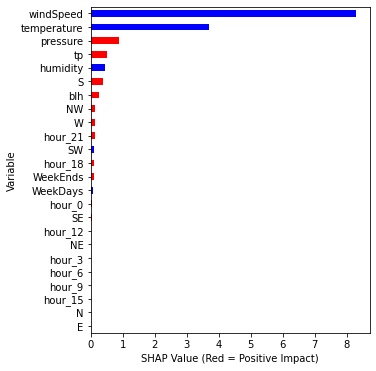

In [152]:
ABS_SHAP(shap_values.values,X_test)